In [ ]:
# # 코랩에서 한글 폰트를 사용하기 위한 과정

# # 1. 아래코드 실행하여 폰트 다운
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

# # 2. 코랩의 런타임 다시시작(단축키:ctrl+M)
# # 3. 런타임 다시시작 완료했으면, 아래코드 실행

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import norm, skew
import datetime
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn')
sns.set(font='NanumBarunGothic', font_scale=2.5)
# sns.set(font='Malgun Gothic', font_scale=2.5) 
plt.rcParams['axes.unicode_minus'] = False

## 데이터 읽어오기

In [ ]:
final=pd.read_csv('/content/drive/Shareddrives/Junnesse 조(빅데이터 분석 경진대회(2차))/데이터셋/final2.csv')
print(final.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66748 entries, 0 to 66747
Data columns (total 35 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   시도명       66748 non-null  object 
 1   시군구명      66748 non-null  object 
 2   개방자치단체코드  66748 non-null  int64  
 3   개방서비스명    66748 non-null  object 
 4   인허가일자     66748 non-null  object 
 5   영업상태구분코드  66748 non-null  int64  
 6   사업장명      66748 non-null  object 
 7   면적        66748 non-null  float64
 8   폐휴업일자     27646 non-null  object 
 9   좌표결측      66748 non-null  float64
 10  경도        66748 non-null  float64
 11  위도        66748 non-null  float64
 12  지역        66748 non-null  object 
 13  호텔        66748 non-null  int64  
 14  모텔        66748 non-null  int64  
 15  하우스       66748 non-null  int64  
 16  호스텔       66748 non-null  int64  
 17  스테이       66748 non-null  int64  
 18  텔         66748 non-null  int64  
 19  리조트       66748 non-null  int64  
 20  콘도        66748 non-null  in

In [ ]:
final.head()

,시도명,시군구명,개방자치단체코드,개방서비스명,인허가일자,영업상태구분코드,사업장명,면적,폐휴업일자,좌표결측,경도,위도,지역,호텔,모텔,하우스,호스텔,스테이,텔,리조트,콘도,여인숙,여관,민박,펜션,풀빌라,장,캠핑,캠프,야영장,글램핑,카라반,관광,파크,면적결측
0,서울특별시,종로구,3000000,관광숙박업,2020-10-23,1,호텔 DM,8.004720,NaN,1.0,127.019390,37.573348,서울특별시 종로구,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
1,서울특별시,종로구,3000000,관광숙박업,2018-06-18,0,JONGRO ALICE,5.632752,2020-10-08,1.0,126.989507,37.575468,서울특별시 종로구,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
2,서울특별시,종로구,3000000,관광숙박업,2019-10-29,1,목시 서울 인사동 호텔,8.694844,NaN,1.0,126.989343,37.572297,서울특별시 종로구,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
3,서울특별시,종로구,3000000,관광숙박업,2019-10-18,1,글루호텔,7.519980,NaN,1.0,127.003960,37.575798,서울특별시 종로구,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
4,서울특별시,종로구,3000000,관광숙박업,2019-10-02,1,나인트리 프리미어 호텔 인사동,10.004950,NaN,1.0,126.983795,37.574552,서울특별시 종로구,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0




* 설명변수  
  - 위치에 대한 정보: 위도, 경도, 시도명, 시군구명, 개방자치단체코드, 지역
  - 업종에 대한 정보: 개방서비스명
  - 인허가 일자에 대한 정보: 인허가일자
  - 사업장명에 대한 정보: 사업장명, 주요 형태소추출을 통한 컬럼들
  - 좌표결측
  - 면적결측
       
* 반응변수    
  - 영업상태구분(영업중/폐휴업): 영업상태구분코드, 폐휴업일자 유무

## EDA와 Feature Engineering

In [ ]:
# 인허가 일자 통계치 확인
final.인허가일자 = final.인허가일자.astype('datetime64[ns]')
final[['인허가일자']].describe()

,인허가일자
count,66748
unique,14925
top,2003-02-26 00:00:00
freq,416
first,1900-01-01 00:00:00
last,2021-12-31 00:00:00


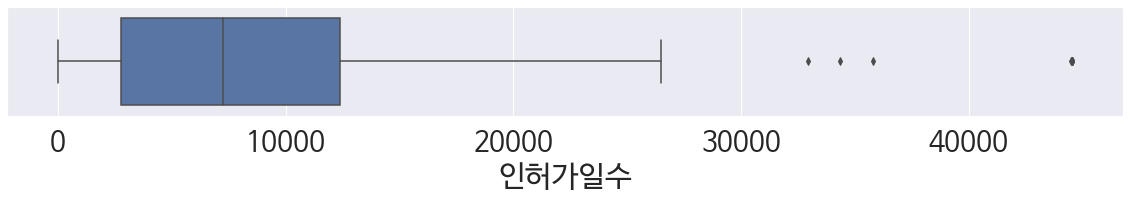

,count,mean,std,min,1%,25%,50%,75%,99%,99.5%,99.9%,max
인허가일수,66748.0,8077.013139,5603.991497,0.0,119.47,2767.5,7249.0,12403.0,20078.59,20730.265,22283.0,44559.0


In [ ]:
# 인허가일자 수치화
# 2021년 12월 31일 기준 창업한지 몇 일이나 되었나?
final.loc[:,'인허가일수'] = final.인허가일자.map(lambda x:datetime.datetime(2021,12,31)-x).astype('str').str.replace(' days','').astype('int')

plt.figure(figsize=(20,2))
sns.boxplot(final['인허가일수'])
plt.show()

stat = final[['인허가일수']].describe(percentiles=(0.01,0.25,0.50,0.75,0.99,0.995,0.999)).transpose()
stat

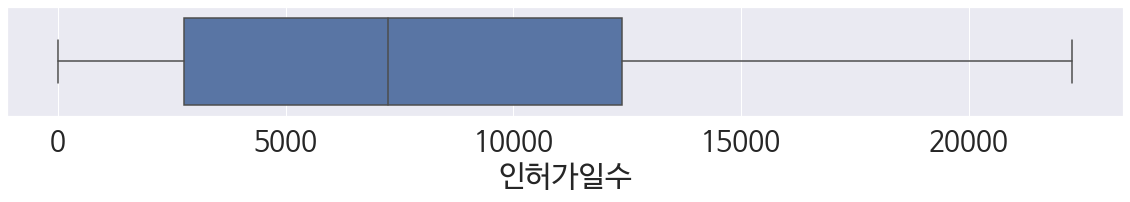

,count,mean,std,min,1%,25%,50%,75%,99%,max
인허가일수,66680.0,8058.581884,5571.728051,0.0,119.0,2761.0,7246.0,12389.0,19960.84,22281.0


In [ ]:
# 99백분위수 미만인 인허가일수 데이터들만 뽑음
op = final[final.인허가일수<stat['99.9%'][0]]

plt.figure(figsize=(20,2))
sns.boxplot(op['인허가일수'])
plt.show()

op[['인허가일수']].describe(percentiles=(0.01,0.25,0.50,0.75,0.99)).transpose()

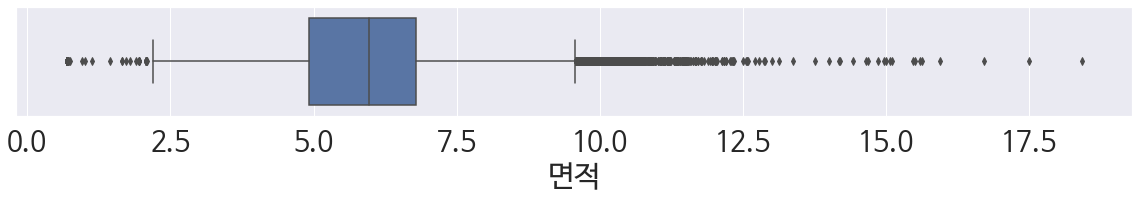

,count,mean,std,min,0.1%,0.5%,1%,25%,50%,75%,99%,99.5%,99.9%,max
면적,66680.0,5.943249,1.388544,0.693147,0.693147,2.397895,3.405312,4.92801,5.971262,6.786613,9.894524,10.377129,11.696027,18.414038


In [ ]:
plt.figure(figsize=(20,2))
sns.boxplot(op['면적'])
plt.show()

stat = op[['면적']].describe(percentiles=(0.001,0.005,0.01,0.25,0.50,0.75,0.99,0.995,0.999)).transpose()
stat

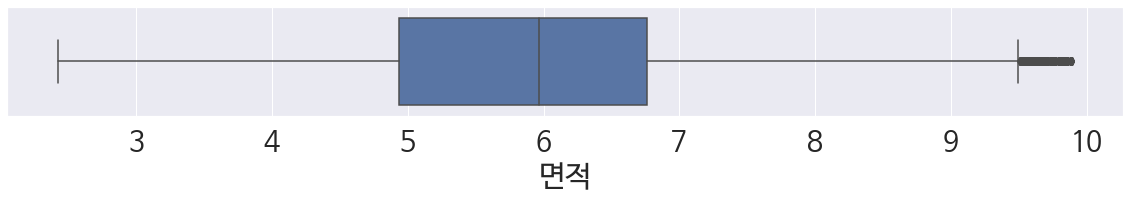

,count,mean,std,min,1%,25%,50%,75%,99%,max
면적,65673.0,5.920346,1.258836,2.424803,3.553823,4.936414,5.965377,6.76207,9.21034,9.894396


In [ ]:
# 0.1백분위수 초과 99.9백분위수 미만인 인허가일수 데이터들만 뽑음
data = op[(stat['0.5%'][0]<op.면적) & (op.면적<stat['99%'][0])]
plt.figure(figsize=(20,2))
sns.boxplot(data['면적'])
plt.show()

data[['면적']].describe(percentiles=(0.01,0.25,0.50,0.75,0.99)).transpose()

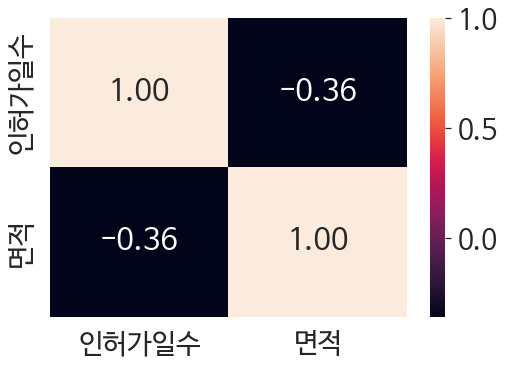

,columns,VIF
0,인허가일수,2.391429
1,면적,2.391429


In [ ]:
# 면적과 인허가일수의 다중공선성 확인

c = data[['인허가일수', '면적']]
corr = c.corr(method='pearson')
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

# VIF(분산팽창요인) 확인
vif = []
train_val = c.values
for i in range(len(c.columns)):
  vif.append(variance_inflation_factor(train_val, i))
  
vif_dataframe = pd.DataFrame()
vif_dataframe['columns'] = c.columns
vif_dataframe['VIF'] = vif
vif_dataframe

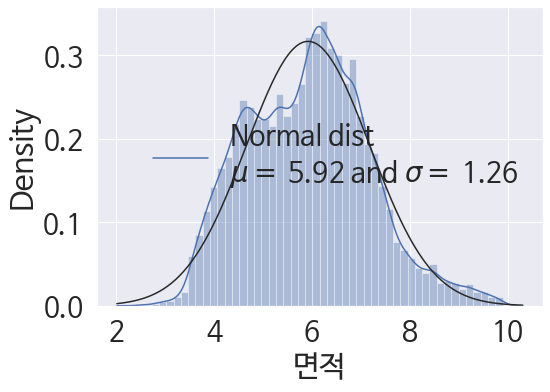

In [ ]:
sns.distplot(data.면적, fit = norm)
(mu, sigma) = norm.fit(data.면적)
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

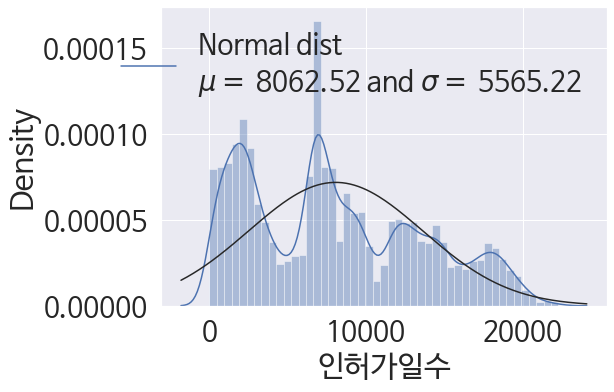

In [ ]:
sns.distplot(data.loc[data['인허가일수'].notnull(), '인허가일수'], fit = norm)
(mu, sigma) = norm.fit(data.loc[data['인허가일수'].notnull(), '인허가일수'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

In [ ]:
col = data.columns.drop(['시도명', '시군구명', '개방자치단체코드', '사업장명', '폐휴업일자','위도','경도', '인허가일자'])
full = data[col]
full = full.reset_index()
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65673 entries, 0 to 65672
Data columns (total 29 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     65673 non-null  int64  
 1   개방서비스명    65673 non-null  object 
 2   영업상태구분코드  65673 non-null  int64  
 3   면적        65673 non-null  float64
 4   좌표결측      65673 non-null  float64
 5   지역        65673 non-null  object 
 6   호텔        65673 non-null  int64  
 7   모텔        65673 non-null  int64  
 8   하우스       65673 non-null  int64  
 9   호스텔       65673 non-null  int64  
 10  스테이       65673 non-null  int64  
 11  텔         65673 non-null  int64  
 12  리조트       65673 non-null  int64  
 13  콘도        65673 non-null  int64  
 14  여인숙       65673 non-null  int64  
 15  여관        65673 non-null  int64  
 16  민박        65673 non-null  int64  
 17  펜션        65673 non-null  int64  
 18  풀빌라       65673 non-null  int64  
 19  장         65673 non-null  int64  
 20  캠핑        65673 non-null  in

In [ ]:
# 원 핫 인코딩 및 데이터 타입 변환

full = pd.get_dummies(full, columns=['개방서비스명', '지역'])
full.인허가일수 = full.인허가일수.astype('float64')
for i in full.columns.drop(['면적','인허가일수']):
    full[i] = full[i].astype('uint8')
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65673 entries, 0 to 65672
Columns: 263 entries, index to 지역_충청북도 충주시
dtypes: float64(2), uint8(261)
memory usage: 17.3 MB


# 모델링

1. xgboost
2. lightbgm

## 필요한 라이브러리 들고오기

In [ ]:
!pip install lightgbm

In [ ]:
!pip install xgboost

In [ ]:
!pip3 install bayesian-optimization

In [ ]:
from bayes_opt import BayesianOptimization
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier, plot_importance
from xgboost import plot_importance, plot_tree
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score

## 데이터 분할

In [ ]:
data = full[full.columns.drop('영업상태구분코드')].to_numpy()
target = full['영업상태구분코드'].to_numpy()

In [ ]:
# 모델을 훈련시킬 train 데이터와 평가할 test 데이터로 나누기 
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.3, random_state=30)

In [ ]:
# train 데이터에서 모델을 검증할 validation 데이터로 분할
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.3, random_state=30)

In [ ]:
print(f'훈련데이터 shape : {sub_input.shape}\n검증데이터 shape : {val_input.shape}\n평가데이터 shape : {train_input.shape}')

훈련데이터 shape : (32179, 262)
검증데이터 shape : (13792, 262)
평가데이터 shape : (45971, 262)


## 단순 모델링

In [ ]:
dt = XGBClassifier(random_state=42,learning_rate=0.03,max_depth=7,subsample=0.9,reg_alpha=0, n_estimators= 10000,tree_method='gpu_hist',gpu_id=0 )
dt.fit(sub_input, sub_target)

print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

print(dt.score(test_input, test_target))

0.9953074986792628
0.8499854988399071
0.8538219470104558


## 하이퍼파라미터 튜닝 및 Feature Importance 검정

In [ ]:
# X에 학습할 데이터를, y에 목표 변수를 저장
X = train_input
y = train_target

## Key는 XGBoost hyperparameter이름이고, value는 탐색할 범위
xgb_parameter_bounds = {'subsample':(0.8,1),'max_depth' : (5,8), 'learning_rate' : (0.01,0.05)}

# 1. 함수에 들어가는 인자 = 위에서 만든 함수의 key값들
# 2. 함수 속 인자를 통해 받아와 새롭게 하이퍼파라미터 딕셔너리 생성
# 3. 그 딕셔너리를 바탕으로 모델 생성
# 4. train_test_split을 통해 데이터 train-valid 나누기
# 5 .모델 학습
# 6. 모델 성능 측정
# 7. 모델의 점수 반환

def xgb_bo(subsample, max_depth, learning_rate):
  xgb_params = {'subsample' : subsample, 'max_depth' : int(round(max_depth)), 'learning_rate' : learning_rate }
  xgb = XGBClassifier(random_state=23,n_estimators=1000,tree_method='gpu_hist', gpu_id=0, **xgb_params)
  X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size = 0.2, )
  xgb.fit(X_train,y_train)
  score = accuracy_score(y_valid, xgb.predict(X_valid))
  return score


# "BO_xgb"라는 변수에 Bayesian Optmization을 저장
BO_xgb = BayesianOptimization(f = xgb_bo, pbounds = xgb_parameter_bounds,random_state = 9,verbose=2)

# Bayesian Optimization을 실행
BO_xgb.maximize(init_points = 5, n_iter = 5)

|   iter    |  target   | learni... | max_depth | subsample |
-------------------------------------------------------------
|  1        |  0.7911   |  0.01041  |  6.506    |  0.8992   |
|  2        |  0.7861   |  0.01535  |  5.426    |  0.8437   |
|  3        |  0.8105   |  0.02674  |  5.744    |  0.8168   |
|  4        |  0.8055   |  0.02382  |  5.5      |  0.9757   |
|  5        |  0.8174   |  0.04804  |  5.116    |  0.9398   |
|  6        |  0.7947   |  0.01092  |  6.557    |  0.9788   |
|  7        |  0.8187   |  0.05     |  5.038    |  0.9688   |
|  8        |  0.8401   |  0.04318  |  7.527    |  0.9922   |
|  9        |  0.7908   |  0.01285  |  5.942    |  0.9691   |
|  10       |  0.837    |  0.0495   |  7.676    |  0.9976   |


In [ ]:
# 하이퍼파라미터의 결과값을 불러와 "max_params"라는 변수에 저장해보세요
xgb_max_params = BO_xgb.max['params']
xgb_max_params['subsample'] = (xgb_max_params['subsample'])
xgb_max_params['max_depth'] = int(xgb_max_params['max_depth'])
xgb_max_params['learning_rate'] = (xgb_max_params['learning_rate'])
print(xgb_max_params)

{'learning_rate': 0.04318130495710891, 'max_depth': 7, 'subsample': 0.9922050187575606}


In [ ]:
# 모델 정의 (튜닝된 파라미터로)
XGBC = XGBClassifier(max_depth = 5, n_estimators = 12000, subsample=0.95, tree_method='gpu_hist', gpu_id=0)
XGBC.fit(train_input, train_target)
print(XGBC.score(test_input, test_target))

0.8683382397726119


accuracy_train: 0.998, accuracy_test: 0.868


[('좌표결측', 0.08057612),
 ('텔', 0.022190005),
 ('개방서비스명_외국인관광도시민박업', 0.02097945),
 ('야영장', 0.013540561),
 ('지역_서울특별시 구로구', 0.013098468),
 ('관광', 0.010312554),
 ('지역_충청남도 서천군', 0.009829045),
 ('면적결측', 0.009058016),
 ('지역_충청남도 공주시', 0.008809088),
 ('풀빌라', 0.008674558)]

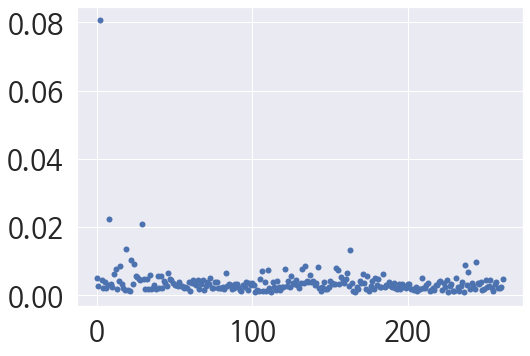

In [ ]:
y_train_pred = XGBC.predict(train_input)
y_test_pred = XGBC.predict(test_input)
print('accuracy_train: %.3f, accuracy_test: %.3f' % (
        accuracy_score(train_target, y_train_pred),
        accuracy_score(test_target, y_test_pred)))

# 피처 중요도 plot을 출력합니다.
importances = XGBC.feature_importances_
plt.plot(importances, "o")

# 피처 중요도를 print로 출력합니다.
feat_labels = full[full.columns.drop('영업상태구분코드')].columns.tolist()
feature = list(zip(feat_labels, XGBC.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

In [ ]:
# X에 학습할 데이터를, y에 목표 변수를 저장
X = train_input
y = train_target

## Key는 LGBM hyperparameter이름이고, value는 탐색할 범위
lgbm_parameter_bounds = {'n_estimators' : (10000,20000), 'max_depth' : (3,6), 'subsample' : (0.5,0.8)}

# 1. 함수에 들어가는 인자 = 위에서 만든 함수의 key값들
# 2. 함수 속 인자를 통해 받아와 새롭게 하이퍼파라미터 딕셔너리 생성
# 3. 그 딕셔너리를 바탕으로 모델 생성
# 4. train_test_split을 통해 데이터 train-valid 나누기
# 5 .모델 학습
# 6. 모델 성능 측정
# 7. 모델의 점수 반환

def lgbm_bo(n_estimators,max_depth, subsample):
  lgbm_params = {'n_estimators' : int(round(n_estimators)), 'max_depth' : int(round(max_depth)), 'subsample' : subsample}
  lgbm = LGBMClassifier(gpu_platform_id=0, **lgbm_params)
  X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size = 0.2, )
  lgbm.fit(X_train,y_train)
  score = accuracy_score(y_valid, lgbm.predict(X_valid))
  return score

# "BO_lgbm"라는 변수에 Bayesian Optmization을 저장
BO_lgbm = BayesianOptimization(f = lgbm_bo, pbounds = lgbm_parameter_bounds,random_state = 0)

# Bayesian Optimization을 실행
BO_lgbm.maximize(init_points = 5, n_iter = 5)


|   iter    |  target   | max_depth | n_esti... | subsample |
-------------------------------------------------------------
|  1        |  0.8439   |  4.646    |  1.715e+0 |  0.6808   |
|  2        |  0.8499   |  4.635    |  1.424e+0 |  0.6938   |
|  3        |  0.8464   |  4.313    |  1.892e+0 |  0.7891   |
|  4        |  0.8498   |  4.15     |  1.792e+0 |  0.6587   |
|  5        |  0.8507   |  4.704    |  1.926e+0 |  0.5213   |
|  6        |  0.8473   |  5.689    |  1.926e+0 |  0.7401   |
|  7        |  0.8472   |  3.691    |  1.958e+0 |  0.615    |


In [ ]:
# 하이퍼파라미터의 결과값을 불러와 "max_params"라는 변수에 저장
lgbm_max_params = BO_lgbm.max['params']
lgbm_max_params['max_depth'] = int(lgbm_max_params['max_depth'])
lgbm_max_params['n_estimators'] = int(lgbm_max_params['n_estimators'])
lgbm_max_params['subsample'] = int(lgbm_max_params['subsample'])
print(lgbm_max_params)

{'max_depth': 3, 'n_estimators': 12754, 'subsample': 0}


In [ ]:
# 모델 정의 (튜닝된 파라미터로)
LGBM = LGBMClassifier(max_depth = 4, n_estimators = 12000, subsample=0.76)
LGBM.fit(train_input, train_target)
print(LGBM.score(test_input, test_target))

0.8648868135214699


accuracy_train: 0.966, accuracy_test: 0.865


[('index', 35336),
 ('인허가일수', 19515),
 ('면적', 19239),
 ('면적결측', 1132),
 ('텔', 1091),
 ('장', 960),
 ('호텔', 653),
 ('개방서비스명_숙박업', 642),
 ('여관', 624),
 ('모텔', 548)]

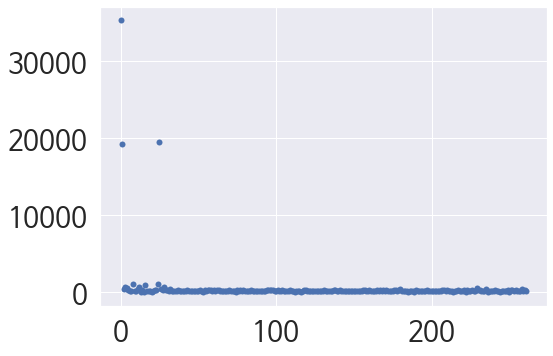

In [ ]:
y_train_pred = LGBM.predict(train_input)
y_test_pred = LGBM.predict(test_input)
print('accuracy_train: %.3f, accuracy_test: %.3f' % (
        accuracy_score(train_target, y_train_pred),
        accuracy_score(test_target, y_test_pred)))

# 피처 중요도 plot을 출력합니다.
importances = LGBM.feature_importances_
plt.plot(importances, "o")

# 피처 중요도를 print로 출력합니다.
feat_labels = full[full.columns.drop('영업상태구분코드')].columns.tolist()
feature = list(zip(feat_labels, LGBM.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]